In [1]:
from google.colab import drive
import pandas as pd
from collections import defaultdict
import numpy as np
import ast
import random
from datetime import datetime, timedelta
import json
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import time

In [2]:
df = pd.read_csv('cleaned_emails.csv')
df.head()

,From,Date,Subject,Body,Recipients,Domains,Label
0,kenny.soignet@enron.com,2000-12-06 05:06:00,AGA for 12/1/00 is -73,AGA for 12/1/00 is -73 Website information: ht...,"['kenny.soignet@enron.com', 'jean.mrha@enron.c...",['gasfundy.corp.enron.com'],0
1,announcements.enron@enron.com,2002-02-22 07:30:36,Outlook Web Access Outage,Enron's external Outlook Web Access (OWA) (htt...,['dl-ga-all_domestic@enron.com'],['mail.enron.com'],0
2,perfmgmt@enron.com,2000-11-06 14:59:00,Year End 2000 Performance Feedback,NOTE: YOU WILL RECEIVE THIS MESSAGE EACH TIME ...,['jane.m.tholt@enron.com'],['pep.corp.enron.com'],0
3,jad.doan@enron.com,2001-10-29 18:11:54,TRV Notification: (CE P/L - 10/29/2001),"The report named: CE P/L , published as of 10/...","['brad.jones@enron.com', 'lisa.kinsey@enron.co...",['trv.corp.enron.com'],0
4,enron.announcements@enron.com,2001-06-05 11:46:00,Managers Training,Attention supervisors and managers! =01; =01; ...,['all.houston@enron.com'],['corptraining.com'],0


In [3]:
df.count()

,0
From,13055
Date,13055
Subject,13055
Body,13055
Recipients,13055
Domains,13055
Label,13055


In [4]:
!pip install openai

In [5]:
import pandas as pd
import random
from datetime import datetime, timedelta
import ast

# Convert columns
df['Date'] = pd.to_datetime(df['Date'])
df['Recipients'] = df['Recipients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [6]:
domain_usage = {}

def track_and_check_domain(domain):
    count = domain_usage.get(domain, 0)
    if count >= 5:
        return False
    domain_usage[domain] = count + 1
    return True

In [7]:
def random_working_hour(date):
    hour = random.randint(9, 17)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(date.year, date.month, date.day, hour, minute, second).strftime('%d-%m-%Y %H:%M:%S')

In [8]:
def select_accounts_with_prior_activity(df, num_accounts=3, months=4):
    candidate_accounts = df['From'].unique().tolist()
    selected = []
    attempts = 0
    used_periods = []

    while len(selected) < num_accounts and attempts < 1000:
        attempts += 1
        sender = random.choice(candidate_accounts)
        sender_dates = df[df['From'] == sender]['Date'].sort_values()
        if len(sender_dates) < 15:
            continue
        earliest_possible = sender_dates.min() + pd.DateOffset(months=months)
        latest_possible = datetime(2002, 7, 13) - pd.DateOffset(months=months)

        if earliest_possible > latest_possible:
            continue

        for _ in range(10):
            start = sender_dates.sample(1).values[0]
            start = pd.Timestamp(start)
            if start < earliest_possible or start > latest_possible:
                continue
            end = start + pd.DateOffset(months=months)
            if all(not (start <= ep_end and end >= ep_start) for (ep_start, ep_end) in used_periods):
                prior_data = df[(df['From'] == sender) & (df['Date'] < start)]
                if len(prior_data) >= 10:
                    selected.append((sender, (start, end)))
                    used_periods.append((start, end))
                    break
    return dict(selected)

account_periods = select_accounts_with_prior_activity(df)

In [9]:
print(account_periods)

{'mike.mcconnell@enron.com': (Timestamp('2001-04-03 06:20:00'), Timestamp('2001-08-03 06:20:00')), 'stephanie.sever@enron.com': (Timestamp('2002-02-06 12:00:12'), Timestamp('2002-06-06 12:00:12')), 'david.delainey@enron.com': (Timestamp('2000-11-07 04:05:00'), Timestamp('2001-03-07 04:05:00'))}


In [10]:
STRATEGIES = {
    "targeted":  {"min_recips": 1,   "max_recips": None},  # all past 30d
    "org_wide":  {"min_recips": 100, "max_recips": 500},
    "randomized":{"min_recips": 50,  "max_recips": 300}
}

In [11]:
import json
import re

def extract_json_from_response(text):
    """
    Extracts the first valid JSON object from a string response.
    Assumes the JSON block is well-formed and surrounded by curly braces.
    """
    try:
        json_str = re.search(r'\{.*\}', text, re.DOTALL).group()
        return json.loads(json_str)
    except (AttributeError, json.JSONDecodeError):
        print("❌ Failed to parse JSON from GPT response:")
        print(text)
        return {
            "Date": "01-01-2000 09:00:00",
            "Subject": "Error generating subject",
            "Body": "Error generating body",
            "Domains": "fallback-domain[.]com"
        }

In [12]:
def generate_phishing_email(sender, recipients, subject_hint=None, blocked_domains=None, force_new=True):
    blocked_list = ", ".join(blocked_domains) if blocked_domains else "none"

    prompt = f"""
You are simulating a **lateral phishing email** sent from a **compromised employee account** inside a company.

This is part of a realistic enterprise phishing campaign using a legitimate internal account to other employees.

Instructions:
- Tone must be casual-professional, like typical workplace emails.
- The body should reference something believable (doc, invoice, access, etc.).
- Include **some phishy-looking URLs** using a **realistic but still phishy domains**
- Format link text like 'Access File' or 'View Document' (trustworthy).
- DO NOT use 'urgent', 'act now', or anything that sounds like spam.
- Generate a date between 01-01-2000 and 13-07-2002 (working hours only).
- Date format: DD-MM-YYYY HH:MM:SS.
- If `subject_hint` is provided, the subject must be: 'Re: {subject_hint}'.
-- If `subject_hint` is not provided, you choose the subject.
- If these domains have already been used ≥5 times, DO NOT use them again: {blocked_list}.

FORMAT (strict JSON):
{{
  "Date": "DD-MM-YYYY HH:MM:SS",
  "Subject": "string",
  "Body": "single-line string with no line breaks",
  "Domains": "the domain used in the phishy URL"
}}

From: {sender}
To: {', '.join(recipients)}
"""

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    content = response.choices[0].message.content
    return extract_json_from_response(content)

In [13]:
def generate_phishing_email_checked(sender, recipients, subject_hint=None):
    max_attempts = 5
    for _ in range(max_attempts):
        blocked_domains = [d for d, count in domain_usage.items() if count >= 5]
        email = generate_phishing_email(sender, recipients, subject_hint, blocked_domains)
        domain = email['Domains']
        if track_and_check_domain(domain):
            return {
                'From': sender,
                'Date': email['Date'],
                'Subject': email['Subject'],
                'Body': email['Body'],
                'Recipients': recipients,
                'Domains': [domain],
                'Label': 1
            }

    # As fallback, allow reused domain
    email = generate_phishing_email(sender, recipients, subject_hint, force_new=False)
    domain_usage[email['Domains']] = domain_usage.get(email['Domains'], 0) + 1
    return {
        'From': sender,
        'Date': email['Date'],
        'Subject': email['Subject'],
        'Body': email['Body'],
        'Recipients': recipients,
        'Domains': [email['Domains']],
        'Label': 1
    }

In [ ]:
from openai import OpenAI

#key

In [15]:
all_dates = pd.date_range(start='2000-01-01', end='2002-07-13', freq='D')
phish_emails = []

email_plan = {}
for sender, (start, end) in account_periods.items():
    email_plan[sender] = {}
    for i in range(4):
        month_start = start + pd.DateOffset(months=i)
        month_str = month_start.strftime('%Y-%m')
        email_plan[sender][month_str] = 10 if i < 3 else 13

for current_day in all_dates:
    for sender, (start, end) in account_periods.items():
        if not (start <= current_day <= end):
            continue

        month_key = current_day.strftime('%Y-%m')
        if email_plan[sender].get(month_key, 0) <= 0:
            continue

        strategy = random.choices(list(STRATEGIES.keys()), weights=[0.3, 0.35, 0.35])[0]

        if strategy == "targeted":
            past_30 = df[
                (df['From'] == sender) &
                (df['Date'] >= current_day - pd.Timedelta(days=30)) &
                (df['Date'] < current_day)
            ]
            possible_recipients = past_30['Recipients'].explode().dropna().unique().tolist()
            if not possible_recipients:
                continue
        elif strategy == "org_wide":
            domain = sender.split('@')[-1]
            possible_recipients = df[df['From'].str.endswith(domain)]['From'].unique().tolist()
        else:
            possible_recipients = df['From'].unique().tolist()

        strat = STRATEGIES[strategy]
        max_recip = strat["max_recips"] or len(possible_recipients)
        recip_count = min(max_recip, len(possible_recipients))
        if recip_count < strat["min_recips"]:
            continue

        recipients = random.sample(possible_recipients, k=recip_count)

        subject_hint = None
        if strategy == "targeted":
            matching = past_30[
                past_30['Recipients'].apply(
                    lambda r: any(x in recipients for x in r) if isinstance(r, list) else False
                )
            ]
            if not matching.empty:
                subject_hint = matching['Subject'].dropna().sample(1).values[0]

        phishing = generate_phishing_email_checked(sender, recipients, subject_hint)
        phishing['Date'] = random_working_hour(current_day)
        phish_emails.append(phishing)
        email_plan[sender][month_key] -= 1
        time.sleep(1)


In [16]:
phish_df = pd.DataFrame(phish_emails)

In [17]:
phish_df.head()

,From,Date,Subject,Body,Recipients,Domains,Label
0,david.delainey@enron.com,08-11-2000 15:41:05,Review Required: Updated Financial Projections,"Hi Kay and David, I've just uploaded the updat...","[kay.chapman@enron.com, david.oxley@enron.com]",[secure-docs-review.com],1
1,david.delainey@enron.com,09-11-2000 09:02:12,Updated Document for Review,"Hi David and Kay, I've shared the updated docu...","[david.oxley@enron.com, kay.chapman@enron.com]",[enron-secure-docs.net],1
2,david.delainey@enron.com,10-11-2000 11:21:10,Monthly Invoice Review,"Hi team, please take a moment to review the at...","[max.brown@enron.com, donna.vaughn@enron.com, ...",[invoice-docs-review.com],1
3,david.delainey@enron.com,11-11-2000 10:28:23,Monthly Financial Overview,"Hi Kay, I’ve uploaded the latest financial ove...",[kay.chapman@enron.com],[enron-financials-review.net],1
4,david.delainey@enron.com,12-11-2000 12:43:21,Monthly Budget Review Documents,"Hi Kay, I’ve compiled the budget review docume...",[kay.chapman@enron.com],[enron-budgetportal-docs.com],1


In [18]:
phish_df.to_csv("generated_phishing_emails.csv", index=False)

In [19]:

# --- Convert column formats ---

# Convert Date columns to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
phish_df['Date'] = pd.to_datetime(phish_df['Date'], dayfirst=True, errors='coerce')

# Convert Recipients and Domains to lists
df['Recipients'] = df['Recipients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['Domains'] = df['Domains'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

phish_df['Recipients'] = phish_df['Recipients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
phish_df['Domains'] = phish_df['Domains'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# --- Add labels ---
df['Label'] = 0
phish_df['Label'] = 1

# --- Ensure same column order ---
common_columns = ['From', 'Date', 'Subject', 'Body', 'Recipients', 'Domains', 'Label']
df_clean = df[common_columns]
phish_clean = phish_df[common_columns]

# --- Combine and shuffle ---
combined_df = pd.concat([df_clean, phish_clean], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [32]:
combined_df.sample(10)

,From,Date,Subject,Body,Recipients,Domains,Label,Month
9982,tana.jones@enron.com,2000-12-05 00:39:00,(00-414) Margin Rate Change for Natural Gas,----- Forwarded by Tana Jones/HOU/ECT on 12/05...,[greg.whiting@enron.com],[208.206.41.61],0,2000-12
5144,chad.landry@enron.com,2001-10-26 08:38:17,RE: Texas Monthly November 2001: How Enron Ble...,call me wehen you get a chance,[matthew.lenhart@enron.com],"[texasmonthly.com, texasmonthly.emailthis.clic...",0,2001-10
5326,perfmgmt@enron.com,2001-05-14 10:50:00,Mid-Year 2001 Performance Feedback,"LOVE, PHILLIP M, ? You have been selected to p...",[phillip.m.love@enron.com],[pep.enron.com],0,2001-05
10327,john.buchanan@enron.com,2001-11-08 07:27:18,FW: Marketing Dashboard Access,Lynn wants all the Customer Service Reps. to h...,"[darrell.schoolcraft@enron.com, chris.greaney@...",[itcentral.enron.com],0,2001-11
10956,d..thomas@enron.com,2001-11-12 12:14:56,DA financial swap,A US Power financial Swap Transaction with Enr...,[rahil.jafry@enron.com],[emrkt.pjm.com],0,2001-11
4300,david.delainey@enron.com,2000-11-13 03:50:00,Approval for reviewer,---------------------- Forwarded by David W De...,[kay.chapman@enron.com],[pep.corp.enron.com],0,2000-11
11655,elizabeth.sager@enron.com,2001-02-27 01:35:00,FW: Revised Energy Chart,chart distributed to isda ----- Forwarded by E...,"[drusso@reliantenergy.com, harlan.e.murphy@dyn...",[allenovery.com],0,2001-02
4239,enron.expertfinder@enron.com,2001-04-17 22:46:00,The Power of Who - expertfinder,The Enron Corporate Policy Committee introduce...,[holden.salisbury@enron.com],[hrglobal.enron.com],0,2001-04
3388,sylvia.hu@enron.com,2001-11-14 06:34:33,"FW: Nov. 14 -- BNA, Inc. Daily Labor Report",User ID: enrondlr PW: bnaweb22,"[gilda.parker@enron.com, bonnie.white@enron.co...","[bna.com, pubs.bna.com, eb.bna.com]",0,2001-11
9661,kay.mann@enron.com,2001-02-01 00:44:00,Re: coop city outline,Thanks. Do you have some free time today? I'm ...,[jrmostel@llgm.com],[explorer.msn.com],0,2001-02


In [37]:
phish_df.sample(10)

,From,Date,Subject,Body,Recipients,Domains,Label
10,david.delainey@enron.com,2000-12-01 14:03:46,Updated Project Document,"Hi team, I just wanted to share the updated do...","[brandon.oliveira@enron.com, dana.davis@enron....",[fileshare-enron-portal.com],1
100,stephanie.sever@enron.com,2002-03-05 12:48:52,Updated Project Files,"Hi team, I have uploaded the latest project fi...","[john.singer@enron.com, mark.breese@enron.com,...",[enron-internal-documents.net],1
123,stephanie.sever@enron.com,2002-05-15 14:35:59,Monthly Expense Report,"Hi team, I've uploaded the latest monthly expe...","[paul.bieniawski@enron.com, charlotte.banks@en...",[enron-expensereview.net],1
21,david.delainey@enron.com,2001-01-02 13:05:39,Monthly Financial Summary,"Hi team, I hope you're all doing well. I've up...","[sunil.abraham@enron.com, darren.espey@enron.c...",[secure-enron-finance-report.org],1
5,david.delainey@enron.com,2000-11-13 13:09:02,Monthly Team Performance Review,"Hi Kay, I hope you're doing well. I've attache...",[kay.chapman@enron.com],[enron-team-review-docs.com],1
68,mike.mcconnell@enron.com,2001-06-06 15:44:23,Monthly Budget Review Document,"Hi team, I've uploaded the latest budget revie...","[ken.lewchuk@enron.com, julie.sarnowski@enron....",[enron-budget-docs.com],1
63,mike.mcconnell@enron.com,2001-06-01 17:03:38,Monthly Sales Report Update,"Hi team, I just finished updating the monthly ...","[axisteam@enron.com, john.henderson@enron.com,...",[internal-enron-docs.com.sales-report-update.com],1
41,david.delainey@enron.com,2001-02-12 15:03:00,Monthly Report Review,"Hi team, I hope this finds you well. I've just...","[charles.ward@enron.com, mark.fischer@enron.co...",[enron-docs-review.com],1
69,mike.mcconnell@enron.com,2001-06-07 12:02:01,Monthly Budget Report,"Hi team, I hope you're all doing well. I've at...","[jason.huang@enron.com, mark.symms@enron.com, ...",[enron-finance-docs.net-secure.com],1
122,stephanie.sever@enron.com,2002-05-14 13:12:35,Updated Project Plan,"Hi team, I've uploaded the latest project plan...","[darren.espey@enron.com, john.norden@enron.com...",[enron-projects-docs.net],1


In [27]:
combined_df.to_csv("combined_emails.csv", index=False)

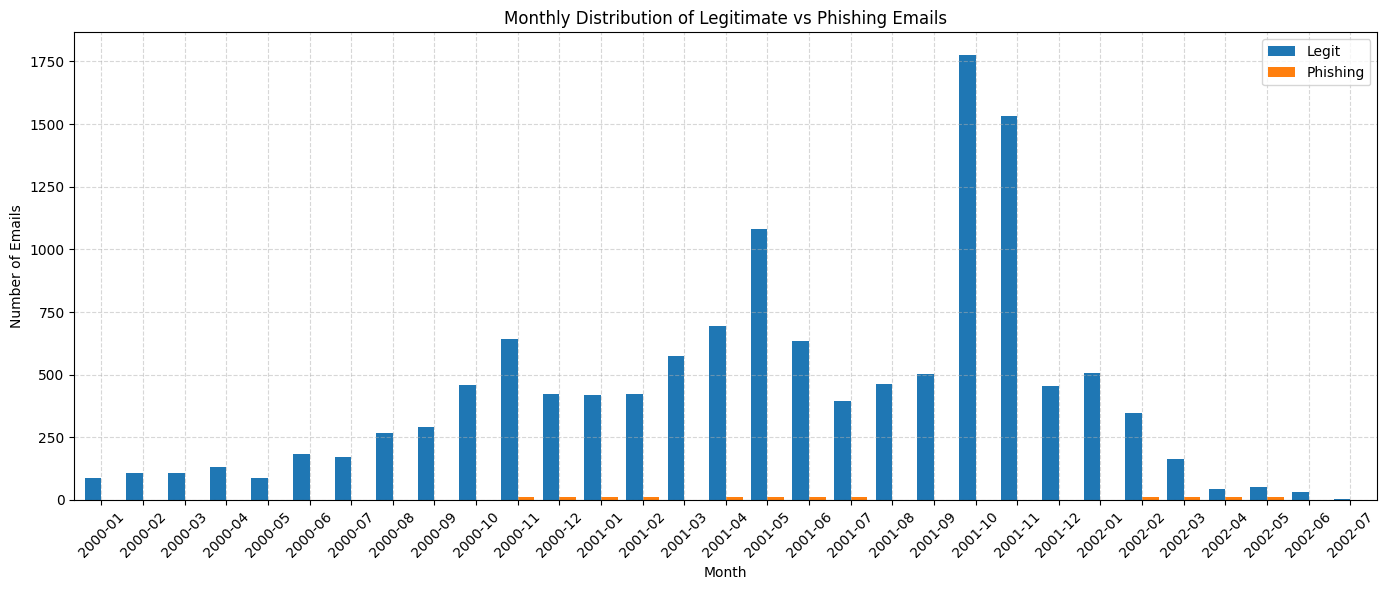

In [28]:
import matplotlib.pyplot as plt

# Ensure 'Date' is datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')

# Extract month
combined_df['Month'] = combined_df['Date'].dt.to_period('M')

# Group by month and label (0 = legit, 1 = phishing)
monthly_counts = combined_df.groupby(['Month', 'Label']).size().unstack(fill_value=0)

# Plot
monthly_counts.plot(kind='bar', figsize=(14, 6), width=0.8)

plt.title("Monthly Distribution of Legitimate vs Phishing Emails")
plt.xlabel("Month")
plt.ylabel("Number of Emails")
plt.legend(["Legit", "Phishing"])
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [29]:
df.isnull().sum()

,0
From,0
Date,0
Subject,0
Body,0
Recipients,0
Domains,0
Label,0


In [38]:
combined_df = combined_df.drop(columns=['Month'])

In [39]:
combined_df.to_csv("final_emails.csv", index=False)

In [40]:
combined_df.count()

,0
From,13184
Date,13184
Subject,13184
Body,13184
Recipients,13184
Domains,13184
Label,13184
